In [3]:
# import necessary packages
import numpy as np
import pandas as pd
import geopandas as gpd
import folium
import json
import matplotlib.pyplot as plt
import fiona
from shapely.geometry import Point

### visualize the path of Hurricane Florence

In [4]:
## get the map of the USA

usa = gpd.read_file("gz_2010_us_040_00_500k.json")
usa.shape
usa.head()

,GEO_ID,STATE,NAME,LSAD,CENSUSAREA,geometry
0,0400000US23,23,Maine,,30842.923,"MULTIPOLYGON (((-67.61976 44.51975, -67.61541 ..."
1,0400000US25,25,Massachusetts,,7800.058,"MULTIPOLYGON (((-70.83204 41.60650, -70.82373 ..."
2,0400000US26,26,Michigan,,56538.901,"MULTIPOLYGON (((-88.68443 48.11579, -88.67563 ..."
3,0400000US30,30,Montana,,145545.801,"POLYGON ((-104.05770 44.99743, -104.25015 44.9..."
4,0400000US32,32,Nevada,,109781.180,"POLYGON ((-114.05060 37.00040, -114.04999 36.9..."


In [6]:
print(type(usa))
print(type(usa.geometry))
print(type(usa.GEO_ID))

<class 'geopandas.geodataframe.GeoDataFrame'>
<class 'geopandas.geoseries.GeoSeries'>
<class 'pandas.core.series.Series'>


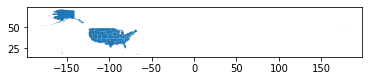

In [8]:
### plot the map of the USA
usa.plot()

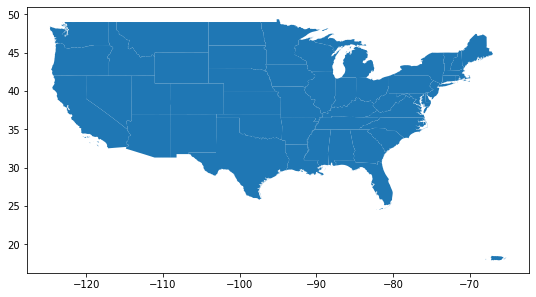

In [9]:
# Execlude Alaska and Hawaii

usa = usa[usa['NAME'].isin(['Alaska', 'Hawaii']) == False]
usa.plot(figsize = (9, 7))

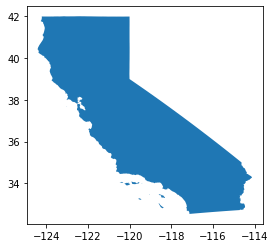

In [10]:
## Where is California

cali = usa.loc[usa.NAME == "California",:]
type(cali)
cali.plot()

In [11]:
## read the florenace hurrican data

florence = pd.read_csv("stormhistory.csv")
florence.head()

,AdvisoryNumber,Date,Lat,Long,Wind,Pres,Movement,Type,Name,Received,Forecaster
0,1,08/30/2018 11:00,12.9,18.4,30,1007,W at 12 MPH (280 deg),Potential Tropical Cyclone,Six,08/30/2018 10:45,Avila
1,1A,08/30/2018 14:00,12.9,19.0,30,1007,W at 12 MPH (280 deg),Potential Tropical Cyclone,Six,08/30/2018 13:36,Avila
2,2,08/30/2018 17:00,12.9,19.4,30,1007,W at 9 MPH (280 deg),Potential Tropical Cyclone,Six,08/30/2018 16:36,Avila
3,2A,08/30/2018 20:00,13.1,20.4,30,1007,W at 11 MPH (280 deg),Potential Tropical Cyclone,Six,08/30/2018 19:44,Beven
4,3,08/30/2018 23:00,13.2,20.9,35,1007,W at 13 MPH (280 deg),Potential Tropical Cyclone,Six,08/30/2018 22:42,Beven


In [13]:
#EDA on florence

print(florence.Wind.min())
print(florence.Wind.max())

25
140


In [14]:
## given that florence is a not a geodataframe, then we
## will need to transform it to a GeoDataFrame with the following steps

## Note: The longtitude should be negative
## This is not necessary always the case
florence['Long'] = 0 - florence['Long']

florence.head()

,AdvisoryNumber,Date,Lat,Long,Wind,Pres,Movement,Type,Name,Received,Forecaster
0,1,08/30/2018 11:00,12.9,-18.4,30,1007,W at 12 MPH (280 deg),Potential Tropical Cyclone,Six,08/30/2018 10:45,Avila
1,1A,08/30/2018 14:00,12.9,-19.0,30,1007,W at 12 MPH (280 deg),Potential Tropical Cyclone,Six,08/30/2018 13:36,Avila
2,2,08/30/2018 17:00,12.9,-19.4,30,1007,W at 9 MPH (280 deg),Potential Tropical Cyclone,Six,08/30/2018 16:36,Avila
3,2A,08/30/2018 20:00,13.1,-20.4,30,1007,W at 11 MPH (280 deg),Potential Tropical Cyclone,Six,08/30/2018 19:44,Beven
4,3,08/30/2018 23:00,13.2,-20.9,35,1007,W at 13 MPH (280 deg),Potential Tropical Cyclone,Six,08/30/2018 22:42,Beven


In [15]:
# step 1: combine the lat and long to create hurricane coordinates
florence['coordinates'] = florence[['Long', 'Lat']].values.tolist()
florence.head()

,AdvisoryNumber,Date,Lat,Long,Wind,Pres,Movement,Type,Name,Received,Forecaster,coordinates
0,1,08/30/2018 11:00,12.9,-18.4,30,1007,W at 12 MPH (280 deg),Potential Tropical Cyclone,Six,08/30/2018 10:45,Avila,"[-18.4, 12.9]"
1,1A,08/30/2018 14:00,12.9,-19.0,30,1007,W at 12 MPH (280 deg),Potential Tropical Cyclone,Six,08/30/2018 13:36,Avila,"[-19.0, 12.9]"
2,2,08/30/2018 17:00,12.9,-19.4,30,1007,W at 9 MPH (280 deg),Potential Tropical Cyclone,Six,08/30/2018 16:36,Avila,"[-19.4, 12.9]"
3,2A,08/30/2018 20:00,13.1,-20.4,30,1007,W at 11 MPH (280 deg),Potential Tropical Cyclone,Six,08/30/2018 19:44,Beven,"[-20.4, 13.1]"
4,3,08/30/2018 23:00,13.2,-20.9,35,1007,W at 13 MPH (280 deg),Potential Tropical Cyclone,Six,08/30/2018 22:42,Beven,"[-20.9, 13.2]"


In [17]:
# Step 2: Change the coordinate to a Point data structure so you
# can add it to a map. The Point method comes from Shapely package

florence['coordinates'] = florence['coordinates'].apply(Point)
florence.head()

,AdvisoryNumber,Date,Lat,Long,Wind,Pres,Movement,Type,Name,Received,Forecaster,coordinates
0,1,08/30/2018 11:00,12.9,-18.4,30,1007,W at 12 MPH (280 deg),Potential Tropical Cyclone,Six,08/30/2018 10:45,Avila,POINT (-18.4 12.9)
1,1A,08/30/2018 14:00,12.9,-19.0,30,1007,W at 12 MPH (280 deg),Potential Tropical Cyclone,Six,08/30/2018 13:36,Avila,POINT (-19 12.9)
2,2,08/30/2018 17:00,12.9,-19.4,30,1007,W at 9 MPH (280 deg),Potential Tropical Cyclone,Six,08/30/2018 16:36,Avila,POINT (-19.4 12.9)
3,2A,08/30/2018 20:00,13.1,-20.4,30,1007,W at 11 MPH (280 deg),Potential Tropical Cyclone,Six,08/30/2018 19:44,Beven,POINT (-20.4 13.1)
4,3,08/30/2018 23:00,13.2,-20.9,35,1007,W at 13 MPH (280 deg),Potential Tropical Cyclone,Six,08/30/2018 22:42,Beven,POINT (-20.9 13.2)


In [18]:
# Step 3: Convert florence from a DataFrame to a GeoDataFrame

florence = gpd.GeoDataFrame(florence, geometry = "coordinates")
type(florence)
florence.head()

,AdvisoryNumber,Date,Lat,Long,Wind,Pres,Movement,Type,Name,Received,Forecaster,coordinates
0,1,08/30/2018 11:00,12.9,-18.4,30,1007,W at 12 MPH (280 deg),Potential Tropical Cyclone,Six,08/30/2018 10:45,Avila,POINT (-18.40000 12.90000)
1,1A,08/30/2018 14:00,12.9,-19.0,30,1007,W at 12 MPH (280 deg),Potential Tropical Cyclone,Six,08/30/2018 13:36,Avila,POINT (-19.00000 12.90000)
2,2,08/30/2018 17:00,12.9,-19.4,30,1007,W at 9 MPH (280 deg),Potential Tropical Cyclone,Six,08/30/2018 16:36,Avila,POINT (-19.40000 12.90000)
3,2A,08/30/2018 20:00,13.1,-20.4,30,1007,W at 11 MPH (280 deg),Potential Tropical Cyclone,Six,08/30/2018 19:44,Beven,POINT (-20.40000 13.10000)
4,3,08/30/2018 23:00,13.2,-20.9,35,1007,W at 13 MPH (280 deg),Potential Tropical Cyclone,Six,08/30/2018 22:42,Beven,POINT (-20.90000 13.20000)


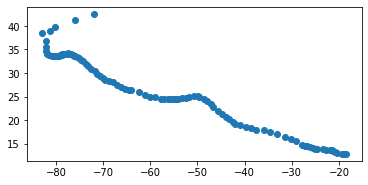

In [19]:
florence.plot()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # Remove the CWD from sys.path while we load stuff.


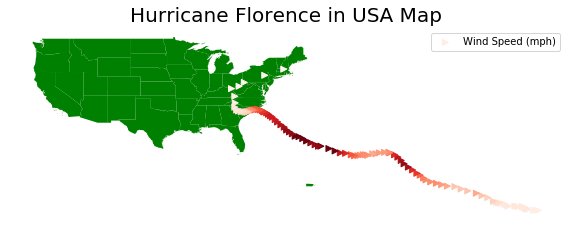

In [20]:
### Visualize the path of the hurricane on top of the USA map

fig, ax = plt.subplots(1, figsize = (10, 7))

base = usa.plot(ax = ax, color = "green")
florence.plot(ax = base, marker = ">", column = "Wind", cmap = "Reds", label = "Wind Speed (mph)")
ax.axis("off")
plt.legend()
plt.title("Hurricane Florence in USA Map", fontsize = 20)
fig.show()

In [21]:
### Use the school_districts.geojson

school_districts = gpd.read_file("school_districts.geojson")
school_districts.head()

,first_name,city,zip,email,state,last_name,address,position,term_expir,district,phone,geometry
0,Dr. Sharon,Nashville,37218,gentryfordistrict1@comcast.net,TN,Gentry,6108 Beals Lane,Member,2016,1,615-268-5269,"MULTIPOLYGON (((-86.77136 36.38357, -86.77134 ..."
1,Jill,Madison,37115,jill.speering@mnps.org,TN,Speering,1033 Falls Avenue,Vice-Chair,2016,3,615-562-5234,"MULTIPOLYGON (((-86.75365 36.40428, -86.75353 ..."
2,Dr. Jo Ann,Nashville,37220,joann.brannon@mnps.org,TN,Brannon,5444 San Marcos Drive,Member,2018,2,615-833-5976,"MULTIPOLYGON (((-86.76696 36.08333, -86.76590 ..."
3,Anna,Hermitage,37076,anna.shepherd@mnps.org,TN,Shepherd,4545 Raccoon Trail,Chair,2018,4,615-210-3768,"MULTIPOLYGON (((-86.58098 36.20935, -86.58099 ..."
4,Amy,Nashville,37221,amy.frogge@mnps.org,TN,Frogge,7237 Riverfront Drive,Member,2016,9,615-521-5650,"MULTIPOLYGON (((-86.97287 36.20828, -86.97045 ..."


In [22]:
type(school_districts)

geopandas.geodataframe.GeoDataFrame

,first_name,city,zip,email,state,last_name,address,position,term_expir,district,phone,geometry
0,Dr. Sharon,Nashville,37218,gentryfordistrict1@comcast.net,TN,Gentry,6108 Beals Lane,Member,2016,1,615-268-5269,"MULTIPOLYGON (((-86.77136 36.38357, -86.77134 ..."
1,Jill,Madison,37115,jill.speering@mnps.org,TN,Speering,1033 Falls Avenue,Vice-Chair,2016,3,615-562-5234,"MULTIPOLYGON (((-86.75365 36.40428, -86.75353 ..."
2,Dr. Jo Ann,Nashville,37220,joann.brannon@mnps.org,TN,Brannon,5444 San Marcos Drive,Member,2018,2,615-833-5976,"MULTIPOLYGON (((-86.76696 36.08333, -86.76590 ..."
3,Anna,Hermitage,37076,anna.shepherd@mnps.org,TN,Shepherd,4545 Raccoon Trail,Chair,2018,4,615-210-3768,"MULTIPOLYGON (((-86.58098 36.20935, -86.58099 ..."
4,Amy,Nashville,37221,amy.frogge@mnps.org,TN,Frogge,7237 Riverfront Drive,Member,2016,9,615-521-5650,"MULTIPOLYGON (((-86.97287 36.20828, -86.97045 ..."


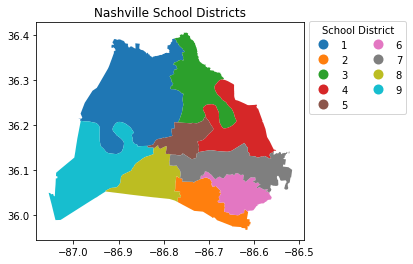

In [23]:
## define some legend parameters

lgnd_kwds = {'title': 'School District',
             'loc': "upper left",
             'bbox_to_anchor': (1, 1.03),
             'ncol' :2 }

school_districts.plot(column = 'district', legend = True,
                     legend_kwds = lgnd_kwds)
plt.title("Nashville School Districts")

school_districts.head()

In [24]:
# inspect the CRS (coordinate reference system)
school_districts.crs

{'init': 'epsg:4326'}

In [25]:
## EPSG: European Petrolum Survey Group
## EPSG:4326 - units are in degrees (Used by Google Earth)
## EPSG:3857 - units are in meters (used by Google Map, Bing Map, Open Street Maps)

# before
school_districts.geometry

0    MULTIPOLYGON (((-86.77136 36.38357, -86.77134 ...
1    MULTIPOLYGON (((-86.75365 36.40428, -86.75353 ...
2    MULTIPOLYGON (((-86.76696 36.08333, -86.76590 ...
3    MULTIPOLYGON (((-86.58098 36.20935, -86.58099 ...
4    MULTIPOLYGON (((-86.97287 36.20828, -86.97045 ...
5    MULTIPOLYGON (((-86.80849 36.14744, -86.80863 ...
6    MULTIPOLYGON (((-86.69728 36.20414, -86.69696 ...
7    MULTIPOLYGON (((-86.70559 36.09685, -86.70306 ...
8    MULTIPOLYGON (((-86.55811 36.13984, -86.55812 ...
Name: geometry, dtype: geometry

In [26]:
# after
## to change from degrees to meter (you might need to override the data to reflect the changes)
school_districts.geometry.to_crs(epsg = 3857)

0    MULTIPOLYGON (((-9659344.056 4353528.767, -965...
1    MULTIPOLYGON (((-9657371.823 4356392.677, -965...
2    MULTIPOLYGON (((-9658854.027 4312092.829, -965...
3    MULTIPOLYGON (((-9638150.956 4329465.543, -963...
4    MULTIPOLYGON (((-9681775.713 4329318.217, -968...
5    MULTIPOLYGON (((-9663476.569 4320928.175, -966...
6    MULTIPOLYGON (((-9651096.617 4328747.062, -965...
7    MULTIPOLYGON (((-9652022.128 4313956.530, -965...
8    MULTIPOLYGON (((-9635605.155 4319880.308, -963...
Name: geometry, dtype: geometry

In [27]:
# GeoSeries area

type(school_districts.geometry)
school_districts.geometry.area ## area in degrees-sq

0    0.036641
1    0.014205
2    0.008328
3    0.014123
4    0.023030
5    0.010704
6    0.006415
7    0.007813
8    0.015004
dtype: float64

In [28]:
school_districts.geometry.to_crs(epsg = 3857).area # area in meter-sq

0    5.631344e+08
1    2.183699e+08
2    1.276154e+08
3    2.168715e+08
4    3.532321e+08
5    1.641375e+08
6    9.846963e+07
7    1.197423e+08
8    2.301357e+08
dtype: float64

In [29]:
# GeoSeries Centroid
center = school_districts.geometry.to_crs(epsg = 3857).centroid
center

0    POINT (-9669306.578 4336855.418)
1    POINT (-9654029.684 4339936.352)
2    POINT (-9651575.219 4304781.406)
3    POINT (-9644681.594 4327762.317)
4    POINT (-9679704.606 4314937.563)
5    POINT (-9665580.354 4312107.938)
6    POINT (-9657204.515 4324033.296)
7    POINT (-9644015.599 4307430.029)
8    POINT (-9645050.503 4315506.700)
dtype: geometry

In [30]:
# GeoSeries Distance

## find the distance between the centers of the first two districts

ctr1 = center[0] # center of first district
ctr2 = center[1] # center of second district

ctr1.distance(ctr2)

15584.468101663197

In [31]:
#### Use Folium package to show the map of USC

import folium
import webbrowser

filepath = "usc_map.html"

In [32]:
m = folium.Map(location = [34.0186834, -118.2860637], zoom_start = 16)
m.save(filepath)
webbrowser.open('file://'+ filepath)

True

In [38]:
## add markers
m = folium.Map(location = [34.0186834, -118.2860637], zoom_start = 16)
folium.Marker([34.0186834, -118.2860637],
              popup = "<b>USC Marshall</b>").add_to(m)
m.save(filepath)
webbrowser.open('file://'+ filepath)

True

In [39]:
## show the logo of USC Marshall as a marker

marshallLogo = "uscmarshall.jpeg"
logoIcon = folium.features.CustomIcon(marshallLogo, icon_size = (50, 50))

folium.Marker([34.0186834, -118.2860637],
              popup = "<b>USC Marshall</b>",
              icon = logoIcon).add_to(m)

m.save(filepath)
webbrowser.open('file://'+ filepath)

True

In [41]:
## show a transparent circle above USC

marshallLogo = "uscmarshall.jpeg"
logoIcon = folium.features.CustomIcon(marshallLogo, icon_size = (50, 50))

folium.Marker([34.0186834, -118.2860637],
              popup = "<b>USC Marshall</b>",
              icon = logoIcon).add_to(m)

folium.CircleMarker([34.0186834, -118.2860637],
                    radius = 150,
                    popup = "University of Southern California",
                    color = "#428bca",
                    fill = True,
                    fill_color = "#428bca").add_to(m)

m.save(filepath)
webbrowser.open('file://'+ filepath)

True